In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy
from scipy import signal
from scipy import linalg


def compute_gradients(img):
    """
    Compute the horizontal and vertical gradients of an input grayscale image using the Sobel operator.

    Args:
    - img: input grayscale image.

    Returns:
    - Ex: horizontal gradient.
    - Ey: vertical gradient.
    """
    Ex = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    Ey = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    return Ex, Ey


def find_corners(local_max):
    """
    Find the coordinates of corners detected using the Harris corner detection algorithm.

    Args:
    - local_max: binary image containing the detected corner points.

    Returns:
    - corners: Nx2 array of (x,y) corner coordinates.
    """
    corners = np.argwhere(local_max > 0)
    return corners


def harris_corner_detector(img, window_size=3, std=1, k=0.05, threshold=0.01):
    """
    Detect corners in an input grayscale image using the Harris corner detection algorithm.

    Args:
    - img: input grayscale image.
    - window_size: size of the Gaussian smoothing window.
    - std: standard deviation of the Gaussian smoothing window.
    - k: Harris corner constant.
    - threshold: threshold value for non-maximum suppression.

    Returns:
    - corners: Nx2 array of (x,y) corner coordinates.
    """
    # Compute image gradients
    Ex, Ey = compute_gradients(img)

    # Compute products of derivatives
    E2X = Ex ** 2
    E2Y = Ey ** 2
    Exy = Ex * Ey

    # Gaussian window for smoothing
    w_mask = signal.windows.gaussian(window_size ** 2, std, sym=True)
    w_mask = w_mask.reshape((window_size, window_size))

    # Sums of products, using Gaussian smoothing
    S2X = signal.convolve2d(E2X, w_mask)
    S2Y = signal.convolve2d(E2Y, w_mask)
    Sxy = signal.convolve2d(Exy, w_mask)

    # Calculate corner response
    det = (S2X * S2Y) - (Sxy ** 2)
    trace = S2X + S2Y
    R = det - k * (trace ** 2)

    # Non-maximum suppression
    _, R = cv2.threshold(R, threshold*R.max(), 255, 0)
    # Find local maxima in the image
    local_max = (R == scipy.ndimage.maximum_filter(R, size=3))

    # Apply threshold to filter out weak maxima
    local_max[R < threshold] = False

    # Set non-maximum values to zero
    corners = R.copy()
    corners[np.logical_not(local_max)] = 0
    corners = corners[1:-1, 1:-1]

    return corners, img + corners


def get_window(img, h, w, window_size=5):
    """
    Get a window of size (2n+1)x(2n+1) centered at (h,w) in the input image.
    Used for NCC calculation

    Args:
    - img: input grayscale image.
    - h: row coordinate of the window center.
    - w: column coordinate of the window center.
    - window_size: size of the window.

    Returns:
    - window: (2n+1)x(2n+1) window of the input image.
    """

    pad_img = np.pad(img, ((window_size, window_size),
                     (window_size, window_size)))
    window = pad_img[h+window_size: h+2 *
                     window_size, w+window_size: w+2*window_size]
    return window


def match_corners(img1, img2, corners1, corners2, window_size=5, threshold=0.99):
    """
    Find corresponding corners between two images using normalized cross-correlation (NCC).Args:
    - img1: first input grayscale image.
    - img2: second input grayscale image.
    - corners1: Nx2 array of (x,y) corner coordinates in the first image.
    - corners2: Nx2 array of (x,y) corner coordinates in the second image.
    - window_size: size of the NCC window.
    - threshold: threshold value for NCC matching.

    Returns:
    - matches: Nx5 array of (x1,y1,x2,y2,NCC) matches, where (x1,y1) and (x2,y2) are the corresponding
    corner coordinates in the two images, and NCC is the normalized cross-correlation value.
    """
    matches = []
    corners1 = find_corners(corners1)
    corners2 = find_corners(corners2)
    for i in range(len(corners1)):
        h1, w1 = corners1[i]
        window1 = get_window(img1, h1, w1, window_size)
        best_match = None
        for j in range(len(corners2)):
            h2, w2 = corners2[j]
            window2 = get_window(img2, h2, w2, window_size)
            ncc = np.sum((window1 - np.mean(window1)) * (window2 - np.mean(window2))) / (
                np.std(window1) * np.std(window2) * window_size ** 2)
            if best_match is None or ncc > best_match[-1]:
                best_match = [h1, w1, h2, w2, ncc]
        if best_match[-1] >= threshold:
            matches.append(best_match)
    matches = np.array(matches)
    return matches


def plot_correspondences(img1, img2, matches):
    """
    Plot the corresponding corners between two images as lines.
    Args:
    - img1: first input grayscale image.
    - img2: second input grayscale image.
    - matches: Nx5 array of (x1,y1,x2,y2,NCC) matches, where (x1,y1) and (x2,y2) are the corresponding
    corner coordinates in the two images, and NCC is the normalized cross-correlation value.

    Returns:
    - None
    """
    w_offset = img2.shape[1]
    matched_imgs = np.hstack([img1, img2])
    plt.imshow(matched_imgs, cmap='gray')
    for i in range(matches.shape[0]):
        if matches[i, -1] >= 0.99:
            plt.plot([matches[i, 1], matches[i, 3] + w_offset],
                     [matches[i, 0], matches[i, 2]], 'r-', linewidth=0.5)
    plt.show()


def RANSAC(matches, trials=500, mindet_null=0.2, dist_thresh=1):
    """
    Apply RANSAC algorithm to estimate homography matrix from matches between two images.

    Args:
    - matches: Nx5 array of (x1,y1,x2,y2,NCC) matches, where (x1,y1) and (x2,y2) are the corresponding
    corner coordinates in the two images, and NCC is the normalized cross-correlation value.
    - trials: number of RANSAC trials to perform.
    - mindet_null: minimum determinant of the homography matrix for it to be considered valid.
    - radius: radius in pixels around the transformed point within which to consider it an inlier.

    Returns:
    - bestscore: number of inliers in the largest set of inliers.
    - bestH: 3x3 homography matrix.
    """
    from random import shuffle
    bestscore = -1
    bestH = None
    correspondence = [(match[0], match[1], match[2], match[3])
                      for match in matches]
    for _ in range(trials):
        shuffle(correspondence)
        points = correspondence[:4]
        H = compute_homography(*points)

        # continue if determinant is too small
        if linalg.det(H) < mindet_null:
            continue

        # compute inliers
        inliers = []
        for j in range(matches.shape[0]):
            # change to homogeneous coordinates
            src_pt = np.array([matches[j, 0], matches[j, 1], 1])
            dst_pt = np.array([matches[j, 2], matches[j, 3], 1])
            transformed = np.matmul(H, src_pt)
            transformed /= transformed[2]
            if np.linalg.norm(transformed[:2] - dst_pt[:2]) < dist_thresh:
                inliers.append(j)
        score = len(inliers)

        if score > bestscore:
            bestscore = score
            bestH = H

    return bestH


def compute_homography(pair1, pair2, pair3, pair4):
    """
    Compute the homography matrix between two sets of corresponding points using RANSAC.

    Args:
    - pair1: 4-tuple of (x1,y1,x2,y2) coordinates of corresponding points.
    - pair2: 4-tuple of (x1,y1,x2,y2) coordinates of corresponding points.
    - pair3: 4-tuple of (x1,y1,x2,y2) coordinates of corresponding points.
    - pair4: 4-tuple of (x1,y1,x2,y2) coordinates of corresponding points.

    Returns:
    - H: 3x3 homography matrix.
    """

    rrefmatr = []
    avec = []
    for pointpair in [pair1, pair2, pair3, pair4]:

        x1, y1, x2, y2 = pointpair[0], pointpair[1], pointpair[2], pointpair[3]
        rrefmatr.append([x1, y1, 1, 0, 0, 0, -x1 * x2, -y1 * x2])
        rrefmatr.append([0, 0, 0, x1, y1, 1, -x1 * y2, -y1 * y2])
        avec.extend([x2, y2])

    rrefmatr = np.asarray(rrefmatr)
    avec = np.asarray(avec)
    try:
        sol = np.matmul(linalg.inv(rrefmatr), np.transpose(avec))
    except:
        return np.zeros([3, 3])
    return np.asarray([[sol[0], sol[1], sol[2]],
                       [sol[3], sol[4], sol[5]],
                       [sol[6], sol[7], 1]])


/Users/ning/opt/anaconda3/envs/torch-mps/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# functions for warping images
# Referenced from EAGrimaldi
def get_warped_boundaries(input_im_hg_pairs):
    """
    Compute the boundaries of the warped images.

    Args:
    - input_im_hg_pairs: list of (image, homography matrix) pairs.

    Returns:
    - (bound_b, bound_r, bound_t, bound_l): boundaries of the warped images.
    - num_channels: number of channels in the warped images.
    """
    bound_b, bound_r, bound_t, bound_l = (0, 0, 0, 0)
    for src, transform in input_im_hg_pairs:
        if len(src.shape) <= 2:
            num_channels = 1
        else:
            max_row, max_col, num_channels = src.shape
        corners = [(0, 0), (max_row - 1, 0), (0, max_col - 1),
                   (max_row - 1, max_col - 1)]
        tf_inv = linalg.inv(transform)
        for corner_i, corner_j in corners:
            dst = np.matmul(tf_inv, np.transpose(np.asarray([corner_i, corner_j, 1])))
            (new_i, new_j, _) = dst / dst[2]
            if new_i > bound_b:
                bound_b = int(new_i)
            elif new_i < bound_t:
                bound_t = int(new_i)
            if new_j > bound_r:
                bound_r = int(new_j)
            elif new_j < bound_l:
                bound_l = int(new_j)
    return (bound_b, bound_r, bound_t, bound_l), num_channels


def mergeImages(input_im_hg_pairs):
    """
    Merge images using homography matrices.

    Args:
    - input_im_hg_pairs: list of (image, homography matrix) pairs.

    Returns:
    - out_mat: merged image.
    """
    (bound_b, bound_r, bound_t, bound_l), num_channels = get_warped_boundaries(
        input_im_hg_pairs)
    num_srcs = len(input_im_hg_pairs)

    out_mat = np.zeros(
        (bound_b - bound_t + 1, bound_r - bound_l + 1, num_channels))
    temp_mat = np.zeros((bound_b - bound_t + 1, bound_r -
                        bound_l + 1, num_srcs, num_channels))
    feather_weights = np.zeros(
        (bound_b - bound_t + 1, bound_r - bound_l + 1, num_srcs, num_channels))
    for warp_row in range(bound_t, bound_b):
        for warp_col in range(bound_l, bound_r):
            out_row = warp_row - bound_t
            out_col = warp_col - bound_l
            for src_idx, (src, transform) in enumerate(input_im_hg_pairs):
                dst = np.matmul(transform, np.transpose(np.asarray([warp_row, warp_col, 1])))
                (from_row, from_col, _) = dst / dst[2]
                if (0 <= from_row < src.shape[0]) and (0 <= from_col < src.shape[1]):
                    i = int(from_row)
                    j = int(from_col)
                    a = from_row - i
                    b = from_col - j
                    p00 = (1 - a) * (1 - b) * src[i, j]
                    if i + 1 < src.shape[0] and j + 1 < src.shape[1]:
                        p10 = a * (1 - b) * src[i + 1, j]
                        p01 = (1 - a) * b * src[i, j + 1]
                        p11 = a * b * src[i + 1, j + 1]
                    elif i + 1 >= src.shape[0] and j + 1 < src.shape[1]:
                        p10 = a * (1 - b) * src[i, j]
                        p01 = (1 - a) * b * src[i, j + 1]
                        p11 = a * b * src[i, j + 1]
                    elif i + 1 < src.shape[0] and j + 1 >= src.shape[1]:
                        p10 = a * (1 - b) * src[i + 1, j]
                        p01 = (1 - a) * b * src[i, j]
                        p11 = a * b * src[i + 1, j]
                    else:
                        p10 = a * (1 - b) * src[i, j]
                        p01 = (1 - a) * b * src[i, j]
                        p11 = a * b * src[i, j]
                    temp_mat[out_row, out_col, src_idx] = p00 + p10 + p01 + p11

                    # feathering
                    feather_weights[out_row, out_col, src_idx] = np.min([
                        from_row,
                        src.shape[0] - 1 - from_row,
                        from_col,
                        src.shape[1] - 1 - from_col
                    ])
    # feathering, cont
    out_mat = np.divide(np.sum(np.multiply(
        temp_mat, feather_weights), axis=2), np.sum(feather_weights, axis=2))

    return out_mat


In [3]:
hallway_path = "./DanaHallWay1"
office_path = "./DanaOffice"
office_files = [filename for filename in sorted(os.listdir(office_path)) if os.path.isfile(os.path.join(office_path, filename))]
#1) read in 2 imgs (if img size is too large --> reduce, and document scale factor used)
#Dana Office images: 
office_images = []    
for i in range(0, len(office_files)): 
    img = cv2.imread(os.path.join(office_path, office_files[i]))
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    office_images.append(gray_img)

office_images = np.array(office_images)
print(office_images.shape)

#Dana Hallway images: 
hallway_files = [filename for filename in sorted(os.listdir(hallway_path)) if os.path.isfile(os.path.join(hallway_path, filename))]

hallway_imgs = []    
for i in range(0, len(hallway_files)): 
    img = cv2.imread(os.path.join(hallway_path, hallway_files[i]))
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hallway_imgs.append(gray_img)

hallway_files = np.array(hallway_imgs)
print(hallway_files.shape)

(10, 340, 512)
(3, 340, 512)


(340, 512)


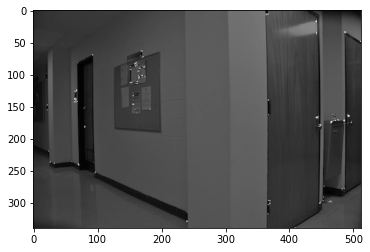

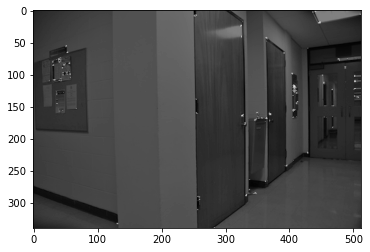

In [4]:
# find Harris corners in the hallway image
print(hallway_files[0].shape)
corners1, img1_corners = harris_corner_detector(hallway_files[0])
corners2, img2_corners = harris_corner_detector(hallway_files[1])
# plot the images
plt.figure()
plt.imshow(img1_corners, cmap='gray')
plt.figure()
plt.imshow(img2_corners, cmap='gray')

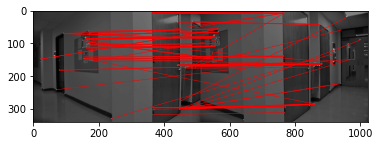

In [5]:
correspondences = match_corners(img1_corners, img2_corners, corners1, corners2)
plot_correspondences(img1_corners, img2_corners, correspondences)

In [6]:
M = RANSAC(correspondences)
print(M)

[[ 1.12360935e+00  6.67046660e-02 -2.16878013e+01]
 [ 5.30795914e-03  1.21730025e+00 -1.51139364e+02]
 [-1.38719638e-05  4.36747397e-04  1.00000000e+00]]


/var/folders/p9/5vfzh_096c74zzgb5t_8f8hr0000gn/T/ipykernel_41201/4279071767.py:96: RuntimeWarning: invalid value encountered in divide
  out_mat = np.divide(np.sum(np.multiply(


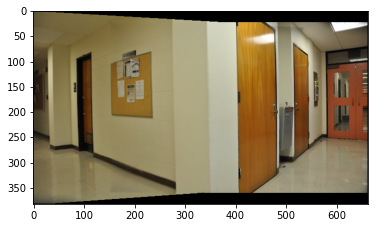

In [14]:
path = ("DanaHallWay1/DSC_0281.JPG", "DanaHallWay1/DSC_0282.JPG")
# read two colorful images
img1 = cv2.imread(path[0])
img2 = cv2.imread(path[1])

mergeIm = mergeImages([(img1, linalg.inv(M)), (img2, np.identity(3))])
mergeIm = cv2.convertScaleAbs(mergeIm)
mergeIm = cv2.cvtColor(mergeIm, cv2.COLOR_BGR2RGB)

# Display the image using plt.imshow
plt.imshow(mergeIm)
plt.show()